In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


data_dir = '/tmp/tfds'

data, info = tfds.load('mnist', data_dir=data_dir,
                       as_supervised=True, with_info=True)
data_train = data['train']
data_test = data['test']


2025-02-11 19:52:01.828886: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/Users/harry/Documents/deep-learning-with-jax/jaxenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 5/5 [00:01<00:00,  3.10 file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


2025-02-11 19:52:07.917662: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


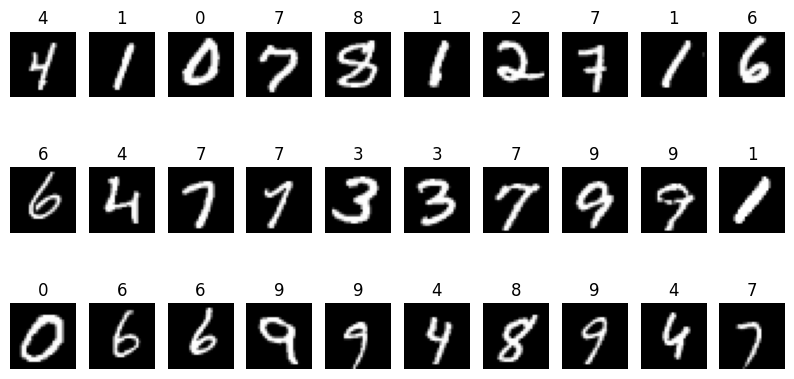

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

ROWS = 3
COLS = 10

i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train.take(ROWS * COLS):
    ax[i // COLS, i % COLS].axis('off')
    ax[i // COLS, i % COLS].imshow(image[:, :, 0], cmap='gray')
    ax[i // COLS, i % COLS].set_title(label.numpy())
    i += 1
plt.show()

In [3]:
HEIGHT = 28
WIDTH = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

def preprocess(img, label):
    """Resize and preprocess images"""
    return (tf.cast(img, tf.float32)/255.0), label

train_data = tfds.as_numpy(
    data_train.map(preprocess).batch(32).prefetch(1))
test_data = tfds.as_numpy(
    data_test.map(preprocess).batch(32).prefetch(1))

In [4]:
from jax import random

LAYER_SIZE = [28*28, 512, 10]
PARAM_SCALE = 0.01

def init_network_params(sizes, key=random.PRNGKey(0), scale=1e-2):
    """initialise all layers for a fully connected neural network with given size"""

    def random_layer_params(m,n, key, scale=1e-2):
        """ A helper function to randomly initialize weights and biases in a dense layers"""

        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale* random.normal(b_key, (n, ))
    
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale)
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

params = init_network_params(LAYER_SIZE, random.PRNGKey(0), scale=PARAM_SCALE)


In [5]:
import jax.numpy as jnp
from jax.nn import swish

def predict(params, image):
    """function for per example predictions"""
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = swish(outputs)
    
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits

In [7]:
random_flattened_image = \
    random.normal(random.PRNGKey(1), (32, 28*28*1,))
try:
    preds = predict(params, random_flattened_image)
except Exception as e:
    print(e)
print(preds)

dot_general requires contracting dimensions to have the same shape, got (784,) and (32,).
[ 0.03004305  0.00918218 -0.05188494  0.00226462  0.00777104  0.00018503
  0.0288451   0.06253068  0.0371264   0.02425937]


In [8]:
from jax import vmap
batched_predictions = vmap(predict, in_axes=(None, 0))

In [9]:
batch_preds = batched_predictions(params, random_flattened_image)
batch_preds.shape

(32, 10)